In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from src.config import RunConfig
from ipywidgets import Text, VBox
import PIL
from src.euler_scheduler import MyEulerAncestralDiscreteScheduler
from src.ddim_scheduler import MyDDIMScheduler
from diffusers.pipelines.auto_pipeline import AutoPipelineForImage2Image
from src.sdxl_inversion_pipeline import SDXLDDIMPipeline
from PIL import Image
from diffusers.utils.torch_utils import randn_tensor
from IPython.display import display

/mnt2/alexdang/miniconda3/envs/newton_raphson/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/mnt2/alexdang/miniconda3/envs/newton_raphson/lib/python3.9/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/mnt2/alexdang/miniconda3/envs/newton_raphson/lib/python3.9/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/mnt2/alexdang/miniconda3/envs/newton_raphson/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_p

In [3]:
def inversion_callback(pipe, step, timestep, callback_kwargs):
    return callback_kwargs


def inference_callback(pipe, step, timestep, callback_kwargs):
    return callback_kwargs


def center_crop(im):
    width, height = im.size  # Get dimensions
    min_dim = min(width, height)
    left = (width - min_dim) / 2
    top = (height - min_dim) / 2
    right = (width + min_dim) / 2
    bottom = (height + min_dim) / 2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    return im


def load_im_into_format_from_path(im_path):
    return center_crop(PIL.Image.open(im_path)).resize((512, 512))

In [4]:
device1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device2 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [5]:
pipe_inversion = SDXLDDIMPipeline.from_pretrained(
    "stabilityai/sdxl-turbo", use_safetensors=True, safety_checker=None, cache_dir=None
).to(device1)
pipe_inference = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/sdxl-turbo", use_safetensors=True, safety_checker=None, cache_dir=None
).to(device2)

/mnt2/alexdang/miniconda3/envs/newton_raphson/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Keyword arguments {'safety_checker': None} are not expected by SDXLDDIMPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
scheduler_type = "ddim"
image_size = (512, 512)
scheduler_class = (
    MyDDIMScheduler if scheduler_type == "ddim" else MyEulerAncestralDiscreteScheduler
)
pipe_inference.scheduler = scheduler_class.from_config(pipe_inference.scheduler.config)
pipe_inversion.scheduler = scheduler_class.from_config(pipe_inversion.scheduler.config)
pipe_inversion.scheduler_inference = scheduler_class.from_config(
    pipe_inference.scheduler.config
)

In [28]:
class ImageEditorDemo:
    def __init__(
        self,
        pipe_inversion,
        inversion_device,
        pipe_inference,
        inference_device,
        input_image,
        description_prompt,
        invert_config,
        edit_cfg,
    ):
        self.pipe_inversion = pipe_inversion
        self.inversion_device = inversion_device
        self.inference_device = inference_device
        self.pipe_inference = pipe_inference
        self.original_image = load_im_into_format_from_path(input_image).convert("RGB")
        self.load_image = True
        g_cpu = torch.Generator(inversion_device).manual_seed(7865)
        img_size = (512, 512)
        VQAE_SCALE = 8
        latents_size = (1, 4, img_size[0] // VQAE_SCALE, img_size[1] // VQAE_SCALE)
        noise = [
            randn_tensor(
                latents_size,
                dtype=torch.float16,
                device=inversion_device,
                generator=g_cpu,
            )
            for i in range(invert_config.num_inversion_steps)
        ]
        if scheduler_type == "euler":
            pipe_inversion.scheduler.set_noise_list(noise)
            pipe_inference.scheduler.set_noise_list(noise)
            pipe_inversion.scheduler_inference.set_noise_list(noise)
        pipe_inversion.set_progress_bar_config(disable=True)
        pipe_inference.set_progress_bar_config(disable=True)
        self.cfg = invert_config
        self.pipe_inversion.cfg = invert_config
        self.pipe_inference.cfg = invert_config
        self.inv_hp = [2, 0.1 * 4 * 64 * 64, 0.2, scheduler_type]

        self.edit_cfg = edit_cfg

        # self.pipe_inference.to("cuda")
        # self.pipe_inversion.to("cuda")

        self.last_latent = self.invert(self.original_image, description_prompt)
        self.original_latent = self.last_latent

    def invert(self, init_image, base_prompt):
        res = self.pipe_inversion(
            self.inversion_device,
            prompt=base_prompt,
            num_inversion_steps=self.cfg.num_inversion_steps,
            num_inference_steps=self.cfg.num_inference_steps,
            image=init_image,
            guidance_scale=self.cfg.guidance_scale,
            callback_on_step_end=inversion_callback,
            strength=self.cfg.inversion_max_step,
            denoising_start=1.0 - self.cfg.inversion_max_step,
            inv_hp=self.inv_hp,
        )[0][0]
        return res

    def edit(self, target_prompt):
        image = self.pipe_inference(
            prompt=target_prompt,
            num_inference_steps=self.cfg.num_inference_steps,
            negative_prompt="",
            callback_on_step_end=inference_callback,
            image=self.last_latent.to(self.inference_device),
            strength=self.cfg.inversion_max_step,
            denoising_start=1.0 - self.cfg.inversion_max_step,
            guidance_scale=self.edit_cfg,
        ).images[0]
        return image

In [63]:
config = RunConfig(
    num_inference_steps=4,
    num_inversion_steps=4,
    guidance_scale=100.0,
    inversion_max_step=0.6,
)

h = display(display_id="my-display")
input_image = "example_images/lion.jpeg"
description_prompt = "a lion is sitting in the grass at sunset"
editor = ImageEditorDemo(
    pipe_inversion,
    device1,
    pipe_inference,
    device2,
    input_image,
    description_prompt,
    config,
    edit_cfg=1.5,
)

0.0 -> 249


IndexError: tensors used as indices must be long, int, byte or bool tensors

In [20]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

text_input = widgets.Text(
    value=description_prompt,
    description="Prompt:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="70%"),
)


def f(x):
    h.update(editor.edit(text_input.value))

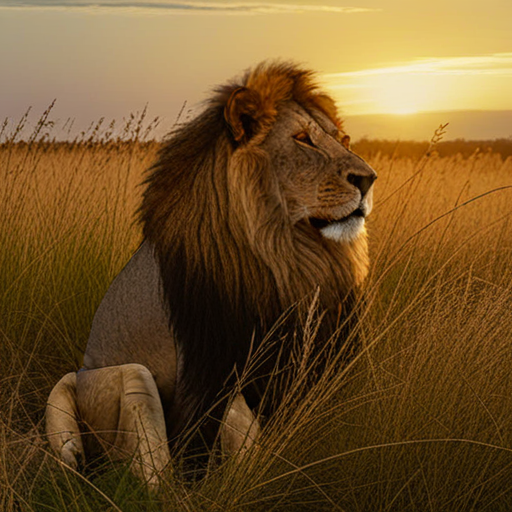

In [60]:
h.display(editor.edit(description_prompt))

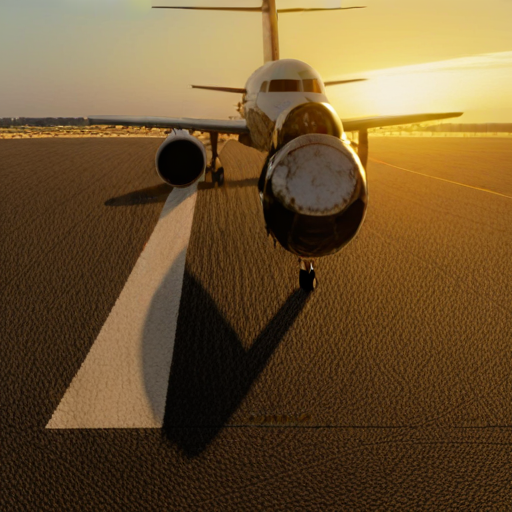

In [62]:
h.display(editor.edit("an airplane on the runway"))

In [ ]:
interact_manual(f, x=text_input)
# a lion is sitting in the grass at sunset
# a raccoon is sitting in the grass at sunset
# a raccoon with a funny hat is sitting in the grass at sunset
# a raccoon with a funny hat is sitting in a green grass at sunset
# a dog with a funny hat is sitting in a green grass at sunset
# a dog with a funny red hat is sitting in a green grass at sunset.
# a dog with a funny red hat is sitting in a green grass on an overcast day.

interactive(children=(Text(value='a lion is sitting in the grass at sunset', continuous_update=False, descript…

<function __main__.f(x)>

In [ ]:
_test_scheduler = scheduler_class.from_config(pipe_inference.scheduler.config)
1 - _test_scheduler.alphas_cumprod
_test_scheduler.betas

tensor([0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0015, 